In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 모든 경고 메시지 무시
warnings.filterwarnings("ignore")

In [23]:
def plot_label_count(exp_path):
    df = pd.read_csv(f"{exp_path}", encoding="UTF-8")

    # target 값을 반올림하여 새로운 컬럼 생성
    df["rounded_target"] = df["target"].round(1)

    plt.figure(figsize=(12, 6))
    # 반올림된 target 값을 기준으로 카운트
    grouped_data = df.groupby("rounded_target")["id"].count()
    grouped_data.plot(kind="bar", color="skyblue")
    plt.title("Label Count")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=0)  # x축 라벨 회전 없애기
    plt.show()


def plot_label_count_df(df):
    plt.figure(figsize=(12, 6))
    grouped_data = df.groupby("target")["id"].count()
    grouped_data.plot(kind="bar", color="skyblue")
    plt.title("label Count")
    plt.xlabel("label")
    plt.ylabel("Count")
    plt.show()


def plot_multiple_label_counts(exp_path):
    num_experiments = len(exp_path)
    num_cols = 2  # 한 줄에 두 개씩 배치
    num_rows = (num_experiments + 1) // num_cols  # 행의 수 계산

    # 전체 subplot 크기 설정
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))  # subplot의 크기 설정

    for idx, exp_path in enumerate(exp_path):
        row = idx // num_cols
        col = idx % num_cols

        # DataFrame 불러오기
        df = pd.read_csv(f"{exp_path}", encoding="UTF-8")

        # 데이터를 그룹화하여 target 별 count 계산
        grouped_data = df.groupby("target")["id"].count()

        # subplot에 각각의 그래프 그리기
        if num_rows > 1:
            ax = axes[row, col]  # 2차원 배열에서 해당 위치의 subplot 지정
        else:
            ax = axes[col]  # 1차원 배열일 경우

        grouped_data.plot(kind="bar", color="skyblue", ax=ax)

        # subplot의 제목 및 축 설정
        ax.set_title(f"Label Count ({idx})")
        ax.set_xlabel("label")
        ax.set_ylabel("Count")

    # 여백 자동 조정
    plt.tight_layout()
    # 그래프 출력
    plt.show()

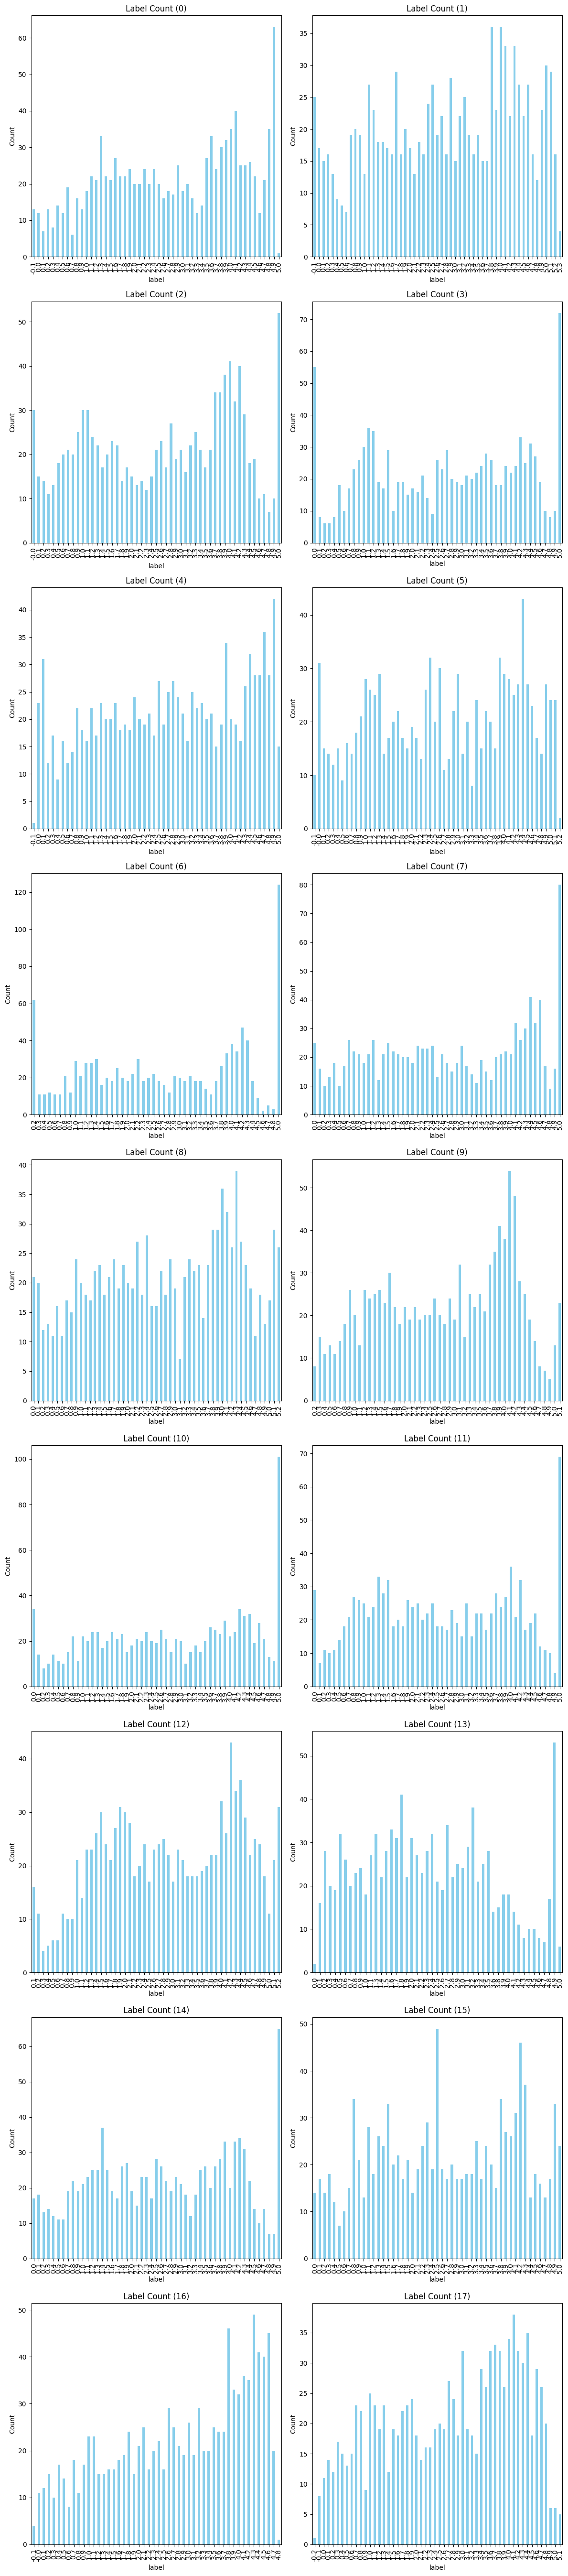

In [31]:
result_path_list = [
    "./results/9017_kakaobank_kf-deberta-base_lr1e-5_batch16_train_augmentV3(minseo)_0.91849.csv",
    "./results/9103_lucid-9103-09-15-10-56.csv",
    "./results/9112_0921_0302_yeseo_mod.csv",
    "./results/9125_klue-roberta-large.csv",
    "./results/9128_team-lucid_deberta-v3-base-korean_lr1e-5_batch16_train_v3_01(minseo)_ 0.93010586.csv",
    "./results/9150_team-lucid_deberta-v3-base-korean_lr1e-5_batch16_train_01(minseo)_0.93004.csv",
    "./results/9166_klue-roberta-large-nnp.csv",
    "./results/9179_snunlp-KR-ELECTRA-discriminator-V1.csv",
    "./results/9191_snunlp:KR-ELECTRA-discriminator ep9.csv",
    "./results/9207_0925_0640_yeseo.csv",
    "./results/9215_kykim-electra-kor-base.csv",
    "./results/9217_snunlp-KR-ELECTRA-discriminator-V2.csv",
    "./results/9236_0924_1313_yeseo.csv",
    "./results/9271_0923_0544_yeseo_nom.csv",
    "./results/9312_0920_1904_yeseo_mod.csv",
    "./results/9316_0922_0611_yeseo_nom.csv",
    "./results/9469_KR-SBERT_split_v1.csv",
    "./results/9556_KR-SBERT_split_v2.csv",
]
score_list = [
    9017,
    9103,
    9112,
    9125,
    9128,
    9150,
    9166,
    9179,
    9191,
    9207,
    9215,
    9217,
    9236,
    9271,
    9312,
    9316,
    9469,
    9556,
]

postprocessing_list = [True] * len(result_path_list)

plot_multiple_label_counts(result_path_list)

In [29]:
from ensemble import ensemble_with_combinations, ensemble_with_metrics, ensemble

# ensemble_with_combinations(result_path_list, score_list, postprocessing_list,5)
ensemble(result_path_list, score_list, postprocessing_list)

In [34]:
# 엔트로피는 값이 높을수록 데이터가 고르게 분포되어 있음을 나타내고, 지니 계수는 값이 낮을수록 고른 분포를 의미

def calculate_entropy(data):
    value_counts = data.value_counts(normalize=True)
    entropy = -np.sum(
        value_counts * np.log2(value_counts + 1e-9)
    )  # 작은 값 추가로 로그 계산시 0 방지
    return entropy


def calculate_gini(data):
    sorted_data = np.sort(data)  # 데이터를 정렬
    n = len(data)

    # 지니 계수 계산
    cumulative_values = np.cumsum(sorted_data)  # 누적 합계
    gini = (2 * np.sum(cumulative_values) / cumulative_values[-1] - (n + 1)) / n

    # 지니 계수는 양수여야 하므로 절대값을 취해 0에서 1 사이로 맞춤
    return np.abs(gini)


def compare_datasets(dataframes):
    results = []

    for idx, df in enumerate(dataframes):
        if "target" not in df.columns:
            print(f"DataFrame {idx} does not contain 'target' column.")
            continue

        entropy = calculate_entropy(df["target"])
        gini = calculate_gini(df["target"])
        results.append({"DataFrame": idx, "Entropy": entropy, "Gini Coefficient": gini})

    results_df = pd.DataFrame(results)
    return results_df

df0 = pd.read_csv("./ensemble_results/3peo_v4 + yeseo(7 model).csv", encoding="UTF-8")
df1 = pd.read_csv("./ensemble_results/ensemble_01.csv", encoding="UTF-8")
df2 = pd.read_csv("./ensemble_results/ensemble_y8_g5_m3_s2.csv", encoding="UTF-8")
df3 = pd.read_csv("./ensemble_results/all_ensemble.csv", encoding="UTF-8")

dataframes = [df0, df1, df2,df3]
comparison_results = compare_datasets(dataframes)
print(comparison_results)

   DataFrame    Entropy  Gini Coefficient
0          0   9.800139          0.307980
1          1  10.103286          0.297423
2          2  10.103286          0.297130
3          3   9.816092          0.311022


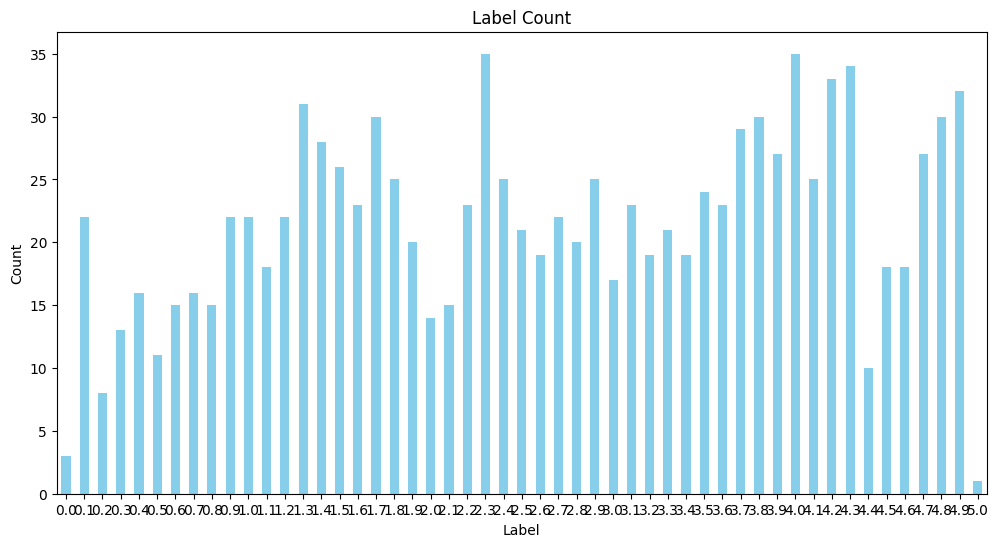

In [20]:
plot_label_count("./ensemble_results/ensemble_01.csv")